<a id='toc'></a>


![readmebanner](https://i.pinimg.com/originals/80/0d/58/800d58c4377ac582c1174125dd83a4f4.png)
![exesummary]()

___

## Workflow

1. [Import](#import)
1. [Acquire Data](#acquire-data)
1. [Clean & Prep Data](#clean-prep-data)
1. [Explore Data](#explore-data)
1. [Split Data](#split-data)
1. [Modeling](#modeling)
    - [Identify Baseline](#identify-baseline)
    - [Model on Train](#model-on-train)
    - [Model on Validate](#model-on-validate)
    - [Model on Test](#model-on-test)
  
7. [Language Prediction](#language-prediction)

8. [Conclusion](#conclusion)


___
# <a name="import"></a>1. Import 
Import all necessary libraries and functions. 

In [1]:
# acquire
import json
from typing import Dict, List, Optional, Union, cast
import requests
import numpy as np
import pandas as pd
from env import github_token, github_username
from requests import get
from bs4 import BeautifulSoup
import os

import acquire_zach as az
import wrangle as w


# prepare
import unicodedata
import re
import json
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

# explore
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
from wordcloud import ImageColorGenerator

# model
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from model import get_metrics

 [Jump to Table of Contents](#toc)
___
# <a name="acquire-data"></a>2. Acquire Data
#### Reads in  `google_readmes1020.csv` from your local file using the `get_aac()` function in [`wrangle.py`](wrangle.py)

In [2]:
df = w.get_readmes()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1020 non-null   object
 1   language         983 non-null    object
 2   readme_contents  1005 non-null   object
dtypes: object(3)
memory usage: 24.0+ KB


Now the story as to scraping this data is a long and arduous one. That I will summarize here:

Using helper functions found in the [`wrangle.py`](wrangle.py) module, I:

1. Created a list of all Google Github Repo Pages:

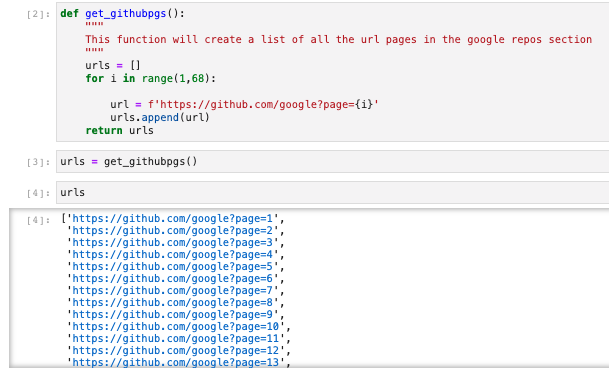


2. Then manually removed pages that had empty repositories (as that gave me so hassle later)

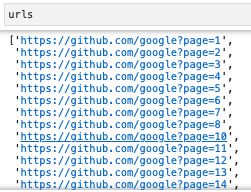

3. I used some more helper functions listed in the [`wrangle.py`](wrangle.py) module to create a list of repository suffixes in small batches to avoid Github putting me on time out for overly scraping their site.

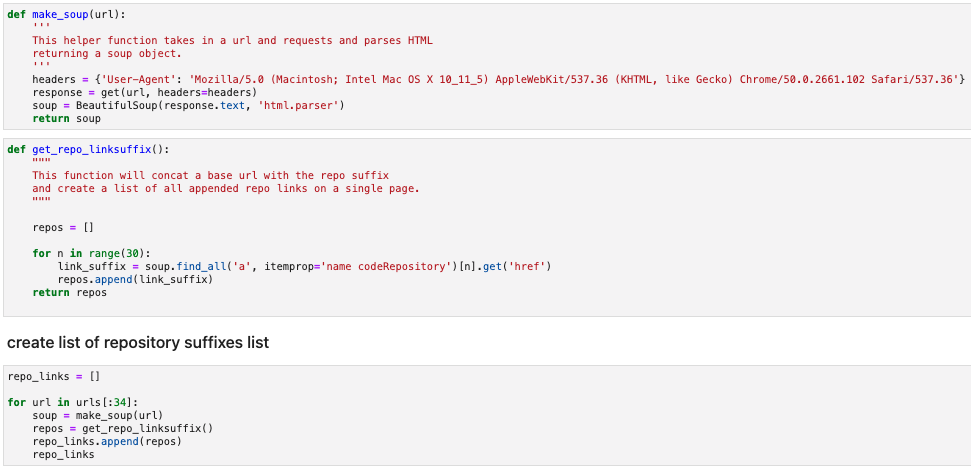


4. Unfortunately that created a nested list of repository page suffixes lists. 😭

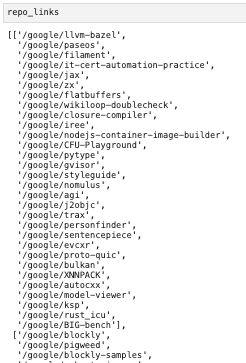

5. So I imported `itertools` library to help me "flatten" my nested list.

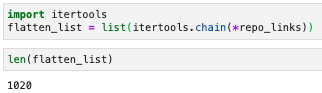

6. When I found my link suffixes on the webpage, it included an unnecessary forward slash. So to quickly remove that character, I transformed my list into a Pandas Series and sliced suffixes to return only the second character forward `reposuffixes.str[1:]` & then converted back to a list `.to_list()`.

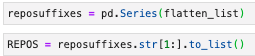

7. Since I had such a long (1020 observations) list of repository suffixes, I wasn't able to simply copy & paste my list into my [`acquire_zach.py`](acquire_zach.py) to call my helper function `scrape_github_data()`, so I ran the entire module in my Jupyter Notebook cell. 
- *In hindsight, I could have neatly sliced the list to copy and & paste all the suffixes into a singluar list, but I was truly running out of time as I ran into so many hiccups just trying to acquire the list of suffixes.*

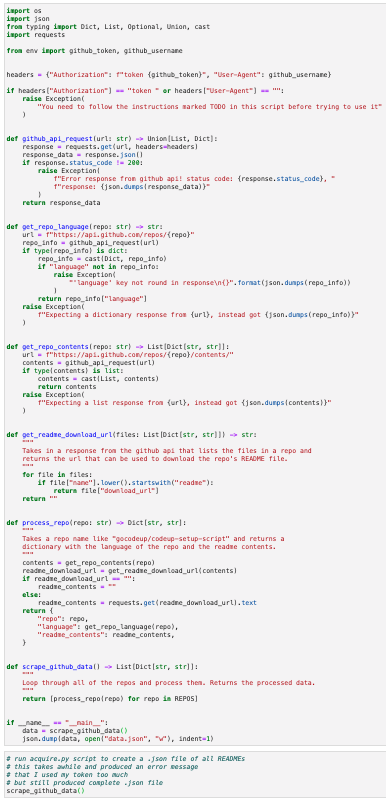

8. Once I successfully scraped a large amount of Google Github `README`'s text as a `.JSON` file, I open and loaded the data, converted to a Panda's DataFrame, and immediately saved the data frame as a `.csv` to avoid even more headaches (as per horror stories of my classmates).

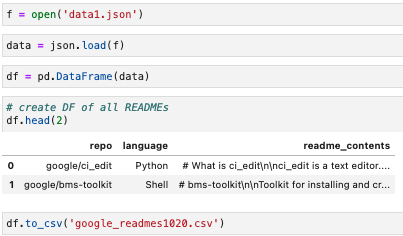

Now, if you'd like to experience this pain first-hand, feel free to use the helper functions provided in 
the [`wrangle.py`](wrangle.py) & [`acquire_zach.py`](acquire_zach.py) modules. But if you'd like to move forward with some already acquired README text, let's move on to Preparing the data...

 [Jump to Table of Contents](#toc)
___
# <a name="clean-prep-data"></a>3. Clean and Prep Data
Using three functions located in `wrangle.py` file:
- [`clean()`](wrangle.py)
- [`get_length()`](wrangle.py)
- [`df_features()`](wrangle.py)

I will perform the cleaning, prepping and splitting of my data:

I had minimal nulls in my data:

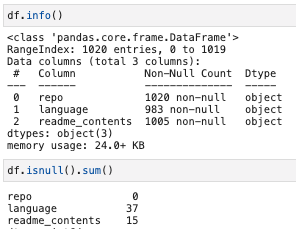

Any empty `README`s or lack of language information was useless to me for this project, so I dropped them.

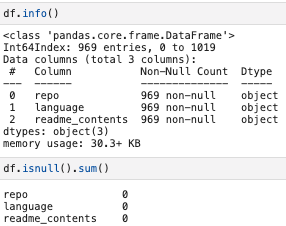

I also wanted to explore data concerning the length of the `README`s so I gatherered that information:

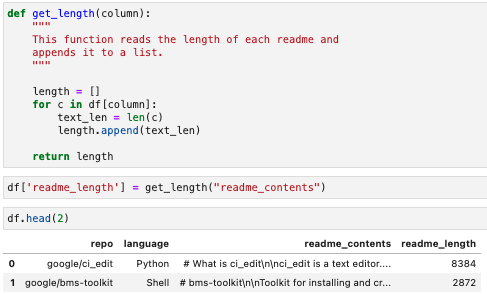

As well as how that compares to the "cleaned" version of the text:

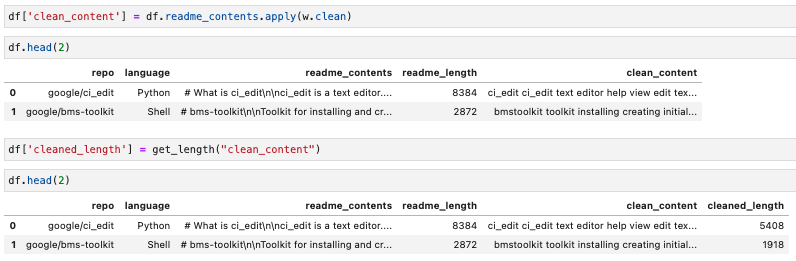

Lucky for you, I have already done all of that work for you, and wrapped it up in a nice [`df_features()`](wrangle.py) bow!


In [4]:
df = w.df_features(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 0 to 1019
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             969 non-null    object
 1   language         969 non-null    object
 2   readme_contents  969 non-null    object
 3   readme_length    969 non-null    int64 
 4   clean_content    969 non-null    object
 5   cleaned_length   969 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 53.0+ KB


In [6]:
df.head(2)

,repo,language,readme_contents,readme_length,clean_content,cleaned_length
0,google/ci_edit,Python,# What is ci_edit\n\nci_edit is a text editor....,8384,ci_edit ci_edit text editor help view edit tex...,5408
1,google/bms-toolkit,Shell,# bms-toolkit\n\nToolkit for installing and cr...,2872,bmstoolkit toolkit installing creating initial...,1918


So let's dig into the data!

 [Jump to Table of Contents](#toc)
___
# <a name="explore-data"></a>4. Explore Data

[Text(0.5, 1.0, 'Distribution of Google Coding Languages in Github Repos'),
 Text(0.5, 0, 'Number of Repos')]

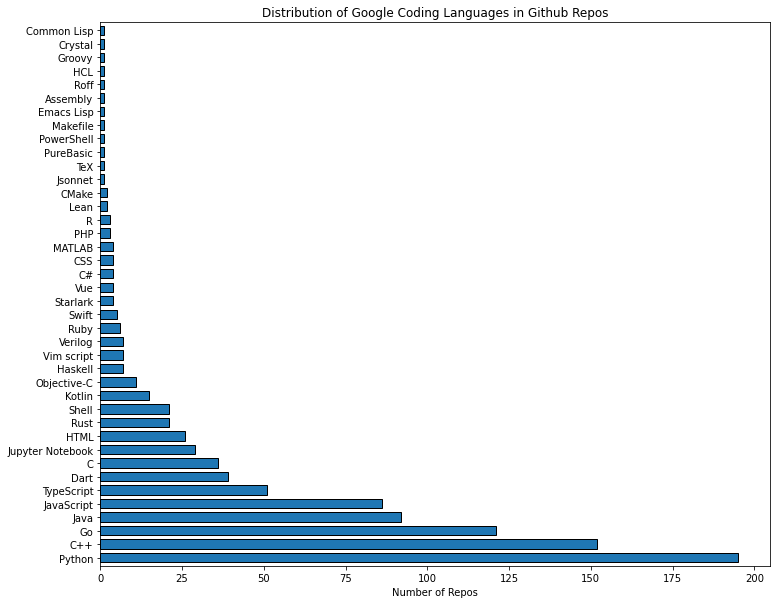

In [13]:
fig = plt.figure(figsize=(12, 10))

ax = df.language.value_counts().plot.barh(width=.7, ec='black')
plt.xticks(rotation=0)
ax.set(title='Distribution of Google Coding Languages in Github Repos', xlabel='Number of Repos')

Text(0, 0.5, '# of READMEs')

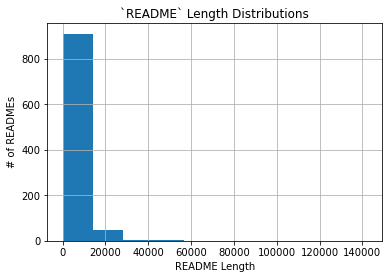

In [99]:
df.readme_length.hist()
plt.title("`README` Length Distributions")
plt.xlabel('README Length')
plt.ylabel('# of READMEs')

In [21]:
df.readme_length.describe()

count       969.000000
mean       4919.704850
std        7116.134426
min          10.000000
25%        1363.000000
50%        2955.000000
75%        5946.000000
max      142109.000000
Name: readme_length, dtype: float64

<AxesSubplot:xlabel='readme_length'>

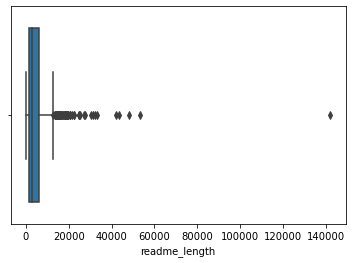

In [22]:
sns.boxplot(data=df, x='readme_length')

In [25]:
df[df.readme_length > 20_000]

,repo,language,readme_contents,readme_length
40,google/glog,C++,Google Logging Library\n======================...,31458
53,google/AFL,C,# american fuzzy lop\n\n[![Build Status](https...,22596
98,google/seqio,Python,"# SeqIO: Task-based datasets, preprocessing, a...",43298
116,google/closure-stylesheets,Java,# Closure Stylesheets\n\nClosure Stylesheets i...,24805
134,google/data-layer-helper,JavaScript,# Data Layer Helper Library\nThis library prov...,25076
156,google/anthos-microk8s,HCL,![Anthos Config Management + Cloud Source Repo...,22477
181,google/stm32_bare_lib,C,# STM32 Bare Library\n\nSystem functions and e...,20784
204,google/basis_universal,C++,# Repository note\n\nThis repository is design...,24865
264,google/jax,Python,"<div align=""center"">\n<img src=""https://raw.gi...",21486
333,google/fscrypt,Go,# fscrypt [![GitHub version](https://badge.fur...,42259


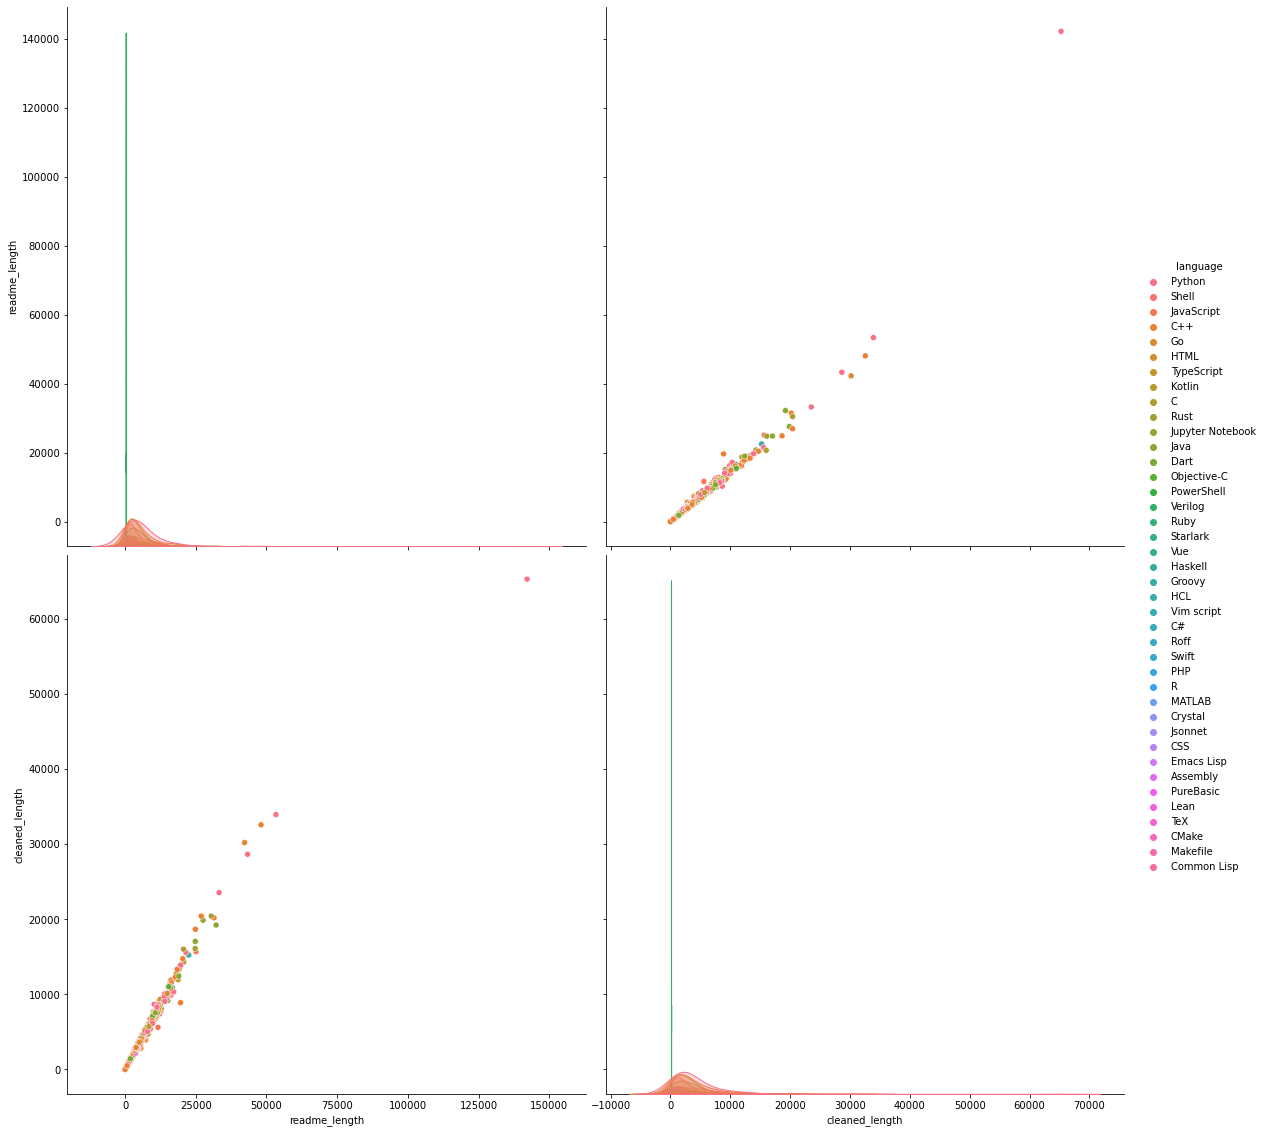

In [33]:
sns.pairplot(df, hue='language', height=8, aspect=1)

I wanted to see a distribution of Bigrams for the Top 5 Languages, but had to create a data frame with their word count and frequency first.


In [36]:
def clean(text, extra_words = ['r', 'u', '2', 'ltgt', "'"]):
    """
    A simple function to cleanup text data:
    takes in a string of text,
    pulls in `nltk`s stopwords and appends any additional `extra_words`
    returns a string filtered for stopwords & lemmatized    
    """
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + extra_words
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [107]:
# create lists of labeled words

python_words = clean(' '.join(df[df.language == 'Python'].readme_contents))
cplusplus_words = clean(' '.join(df[df.language == 'C++'].readme_contents))
go_words = clean(' '.join(df[df.language == 'Go'].readme_contents))
java_words = clean(' '.join(df[df.language == 'Java'].readme_contents))
javascript_words = clean(' '.join(df[df.language == 'JavaScript'].readme_contents))
typescript_words = clean(' '.join(df[df.language == 'TypeScript'].readme_contents))
dart_words = clean(' '.join(df[df.language == 'Dart'].readme_contents))
c_words = clean(' '.join(df[df.language == 'C'].readme_contents))
jupyternotebook_words = clean(' '.join(df[df.language == 'Jupyter Notebook'].readme_contents))
html_words = clean(' '.join(df[df.language == 'HTML'].readme_contents))
shell_words = clean(' '.join(df[df.language == 'Shell'].readme_contents))
rust_words = clean(' '.join(df[df.language == 'Rust'].readme_contents))
kotlin_words = clean(' '.join(df[df.language == 'Kotlin'].readme_contents))
objective_c_words = clean(' '.join(df[df.language == 'Objective-C'].readme_contents))
verilog_words = clean(' '.join(df[df.language == 'Verilog'].readme_contents))
vimscript_words = clean(' '.join(df[df.language == 'Vim script'].readme_contents))
haskell_words = clean(' '.join(df[df.language == 'Haskell'].readme_contents))
ruby_words = clean(' '.join(df[df.language == 'Ruby'].readme_contents))
swift_words = clean(' '.join(df[df.language == 'Swift'].readme_contents))
vue_words = clean(' '.join(df[df.language == 'Vue'].readme_contents))
matlab_words = clean(' '.join(df[df.language == 'MATLAB'].readme_contents))
c_sharp_words = clean(' '.join(df[df.language == 'C#'].readme_contents))
starlark_words = clean(' '.join(df[df.language == 'Starlark'].readme_contents))
css_words = clean(' '.join(df[df.language == 'CSS'].readme_contents))
r_words = clean(' '.join(df[df.language == 'R'].readme_contents))
php_words = clean(' '.join(df[df.language == 'PHP'].readme_contents))
cmake_words = clean(' '.join(df[df.language == 'CMake'].readme_contents))
lean_words = clean(' '.join(df[df.language == 'Lean'].readme_contents))
jsonnet_words = clean(' '.join(df[df.language == 'Jsonnet'].readme_contents))
groovy_words = clean(' '.join(df[df.language == 'Groovy'].readme_contents))
assembly_words = clean(' '.join(df[df.language == 'Assembly'].readme_contents))
makefile_words = clean(' '.join(df[df.language == 'Makefile'].readme_contents))
crystal_words = clean(' '.join(df[df.language == 'Crystal'].readme_contents))
emacslisp_words = clean(' '.join(df[df.language == 'Emacs Lisp'].readme_contents))
commonlisp_words = clean(' '.join(df[df.language == 'Common Lisp'].readme_contents))
powershell_words = clean(' '.join(df[df.language == 'PowerShell'].readme_contents))
tex_words = clean(' '.join(df[df.language == 'TeX'].readme_contents))
roff_words = clean(' '.join(df[df.language == 'Roff'].readme_contents))
purebasic_words = clean(' '.join(df[df.language == 'PureBasic'].readme_contents))
hcl_words = clean(' '.join(df[df.language == 'HCL'].readme_contents))
all_words = clean(' '.join(df.readme_contents))

In [108]:
# create a pd.Series of the value_counts of the list

python_freq = pd.Series(python_words).value_counts()
cplusplus_freq = pd.Series(cplusplus_words).value_counts()
go_freq = pd.Series(go_words).value_counts()
java_freq = pd.Series(java_words).value_counts()
javascript_freq = pd.Series(javascript_words).value_counts()
typescript_freq = pd.Series(typescript_words).value_counts()
dart_freq = pd.Series(dart_words).value_counts()
c_freq = pd.Series(c_words).value_counts()
jupyternotebook_freq = pd.Series(jupyternotebook_words).value_counts()
html_freq = pd.Series(html_words).value_counts()
shell_freq = pd.Series(shell_words).value_counts()
rust_freq = pd.Series(rust_words).value_counts()
kotlin_freq = pd.Series(kotlin_words).value_counts()
objective_c_freq = pd.Series(objective_c_words).value_counts()
verilog_freq = pd.Series(verilog_words).value_counts()
vimscript_freq = pd.Series(vimscript_words).value_counts()
haskell_freq = pd.Series(haskell_words).value_counts()
ruby_freq = pd.Series(ruby_words).value_counts()
swift_freq = pd.Series(swift_words).value_counts()
vue_freq = pd.Series(vue_words).value_counts()
matlab_freq = pd.Series(matlab_words).value_counts()
c_sharp_freq = pd.Series(c_sharp_words).value_counts()
starlark_freq = pd.Series(starlark_words).value_counts()
css_freq = pd.Series(css_words).value_counts()
r_freq = pd.Series(r_words).value_counts()
php_freq = pd.Series(php_words).value_counts()
cmake_freq = pd.Series(cmake_words).value_counts()
lean_freq = pd.Series(lean_words).value_counts()
jsonnet_freq = pd.Series(jsonnet_words).value_counts()
groovy_freq = pd.Series(groovy_words).value_counts()
assembly_freq = pd.Series(assembly_words).value_counts()
makefile_freq = pd.Series(makefile_words).value_counts()
crystal_freq = pd.Series(crystal_words).value_counts()
emacslisp_freq = pd.Series(emacslisp_words).value_counts()
commonlisp_freq = pd.Series(commonlisp_words).value_counts()
powershell_freq = pd.Series(powershell_words).value_counts()
tex_freq = pd.Series(tex_words).value_counts()
roff_freq = pd.Series(roff_words).value_counts()
purebasic_freq = pd.Series(purebasic_words).value_counts()
hcl_freq = pd.Series(hcl_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [110]:
freq_list_str = [
    "python_freq", 
    "cplusplus_freq", 
    "go_freq", 
    "java_freq", 
    "javascript_freq", 
    "typescript_freq", 
    "dart_freq", 
    "c_freq", 
    "jupyternotebook_freq", 
    "html_freq", 
    "shell_freq", 
    "rust_freq", 
    "kotlin_freq", 
    "objective_c_freq", 
    "verilog_freq", 
    "vimscript_freq", 
    "haskell_freq", 
    "ruby_freq", 
    "swift_freq", 
    "vue_freq", 
    "matlab_freq", 
    "c_sharp_freq", 
    "starlark_freq", 
    "css_freq", 
    "r_freq", 
    "php_freq", 
    "cmake_freq", 
    "lean_freq", 
    "jsonnet_freq", 
    "groovy_freq", 
    "assembly_freq", 
    "makefile_freq", 
    "crystal_freq", 
    "emacslisp_freq", 
    "commonlisp_freq", 
    "powershell_freq", 
    "tex_freq", 
    "roff_freq", 
    "purebasic_freq", 
    "hcl_freq", 
    "all_freq"
]

In [114]:
lang_list_str = [
    "python", 
    "cplusplus", 
    "go", 
    "java", 
    "javascript", 
    "typescript", 
    "dart", 
    "c", 
    "jupyternotebook", 
    "html", 
    "shell", 
    "rust", 
    "kotlin", 
    "objective_c", 
    "verilog", 
    "vimscript", 
    "haskell", 
    "ruby", 
    "swift", 
    "vue", 
    "matlab", 
    "c_sharp", 
    "starlark", 
    "css", 
    "r", 
    "php", 
    "cmake", 
    "lean", 
    "jsonnet", 
    "groovy", 
    "assembly", 
    "makefile", 
    "crystal", 
    "emacslisp", 
    "commonlisp", 
    "powershell", 
    "tex", 
    "roff", 
    "purebasic", 
    "hcl", 
    "all"
]

In [115]:
# create a pd.DataFrame of the concated series of value_counts

word_counts = (pd.concat(freq_list, axis=1, sort=True)
                .set_axis(lang_list_str, axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [19]:
top_5_languages = [python_words, cplusplus_words, go_words, java_words, javascript_words]

This loop prints out the Top 20 Bigrams for the Top 5 Languages in the order of: 
- Python
- C++
- Go
- Java
- Javascript

In [22]:
for language in top_5_languages:
    bigrams = (pd.Series(nltk.ngrams(language, 2))
                      .value_counts()
                      .head(20))
    print(f'''
    ___________
    Bigrams:''')
    print(bigrams)


    ___________
    Bigrams:
(20, 20)                   206
(pip, install)             117
(google, product)          101
(google, cloud)             96
(binding, spec)             61
(official, google)          59
(officially, supported)     52
(supported, google)         52
(make, sure)                50
(open, source)              50
(git, clone)                49
(service, account)          47
(python, import)            47
(neural, network)           44
(def, __init__self)         39
(arg, name)                 38
(0a, 20)                    36
(following, command)        35
(bash, python)              35
(codeblock, python)         34
dtype: int64

    ___________
    Bigrams:
(google, product)          72
(git, clone)               69
(source, code)             56
(command, line)            53
(bazel, build)             53
(cmake, build)             41
(supported, google)        40
(officially, supported)    39
(run, test)                39
(visual, studio)           38
(offici

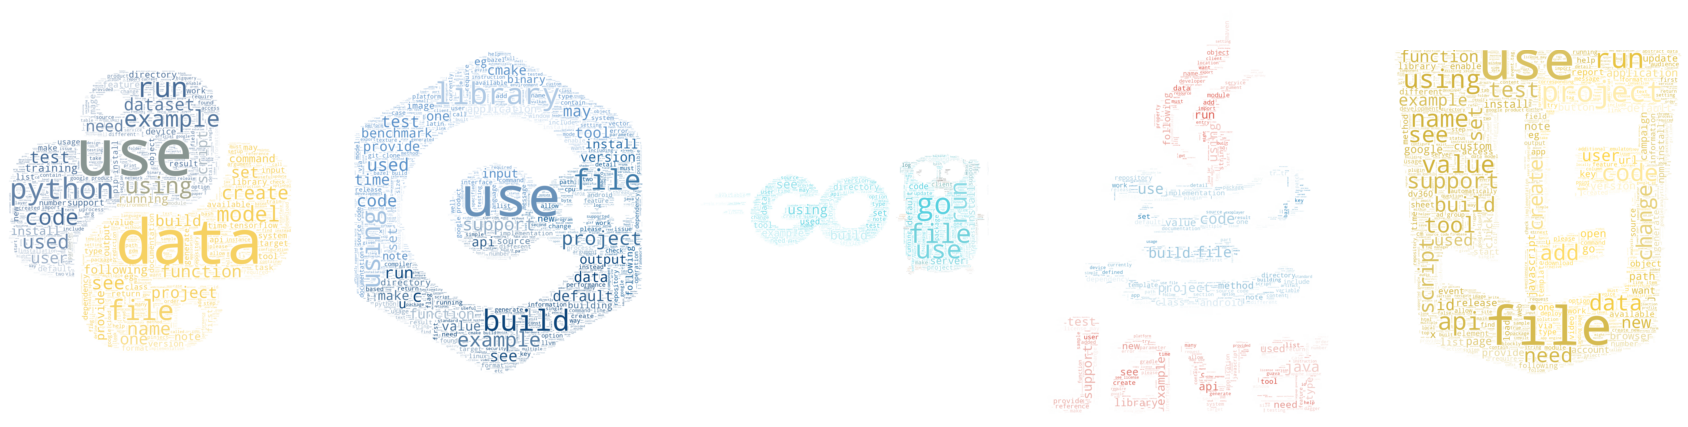

In [24]:
mask1 = np.array(Image.open("pythonimg.jpg"))
wc1 = WordCloud(mask=mask1, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc1.generate(' '.join(python_words))
image_colors1 = ImageColorGenerator(mask1)

mask2 = np.array(Image.open("c++.jpg"))
wc2 = WordCloud(mask=mask2, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc2.generate(' '.join(cplusplus_words))
image_colors2 = ImageColorGenerator(mask2)

mask3 = np.array(Image.open("go.jpg"))
wc3 = WordCloud(mask=mask3, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc3.generate(' '.join(go_words))
image_colors3 = ImageColorGenerator(mask3)

mask4 = np.array(Image.open("java.jpg"))
wc4 = WordCloud(mask=mask4, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc4.generate(' '.join(java_words))
image_colors4 = ImageColorGenerator(mask4)

mask5 = np.array(Image.open("js.jpg"))
wc5 = WordCloud(mask=mask5, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc5.generate(' '.join(javascript_words))
image_colors5 = ImageColorGenerator(mask5)

fig, axes = plt.subplots(1, 5, figsize=(30, 10))

axes[0].imshow(wc1.recolor(color_func=image_colors1), interpolation="bilinear")
axes[1].imshow(wc2.recolor(color_func=image_colors2), interpolation="bilinear")
axes[2].imshow(wc3.recolor(color_func=image_colors3), interpolation="bilinear")
axes[3].imshow(wc4.recolor(color_func=image_colors4), interpolation="bilinear")
axes[4].imshow(wc5.recolor(color_func=image_colors5), interpolation="bilinear")

for ax in axes:
    ax.set_axis_off()
plt.show()

Text(0.5, 1.0, 'Proportion of Top 5 Google Github Repo Languages for the 20 most common words')

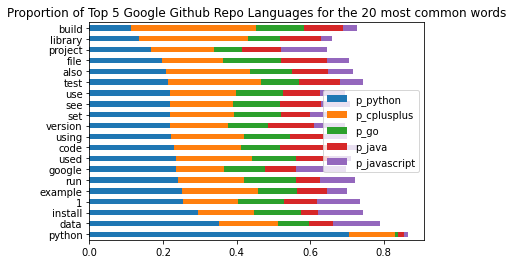

In [119]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_cplusplus=word_counts.cplusplus / word_counts['all'],
         p_go=word_counts.go / word_counts['all'],
         p_java=word_counts.java / word_counts['all'],
         p_javascript=word_counts.javascript / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_cplusplus', 'p_go', 'p_java', 'p_javascript']]
 .tail(20)
 .sort_values('p_python', ascending=False)
 .plot.barh(stacked=True))

plt.title('Proportion of Top 5 Google Github Repo Languages for the 20 most common words')

They can also be visualized in Word Clouds!

<div class="alert alert-block alert-success">

### Takeaways 
Top 5 Languages:
    - `Python`
    - `C++`
    - `Go`
    - `Java`
    - `Javascript`
- README length:
    - Median: 2955
    - Max: 142,109
    - Min: 10
- Long README's language varied
- There are a **lot** of languages to choose from in the Google repos, filtering that down will be essential.
</div>  

 [Jump to Table of Contents](#toc)
___
# <a name="split-data"></a>5. Split Data

### I will use two helper functions located in `wrangle.py` file:

- [`tvt_split`](wrangle.py)
- [`split_Xy()`](wrangle.py)

In [8]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = w.split_Xy(top_15, "language", "clean_content")

In [9]:
# Check shape of all 
train.shape, validate.shape, test.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((504, 6), (217, 6), (181, 6), (504,), (504,), (217,), (217,), (181,), (181,))

# I will be using the sklearn Model to scale/vectorize my data:
- make the thing
- fit the thing 
- use the thing


In [11]:
# Create the tfidf vectorizer object
tfidf = TfidfVectorizer()

# Fit on the training data
tfidf.fit(X_train)

# Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

 [Jump to Table of Contents](#toc)
___
# <a name="modeling"></a>6. Modeling

### Like I stated earlier, narrowing down languages will help me in the modeling process

In [7]:
top_15_languages = df.language.value_counts().index[0:15]
top_15 = df[df.language.isin(top_15_languages)]
top_15

,repo,language,readme_contents,readme_length,clean_content,cleaned_length
0,google/ci_edit,Python,# What is ci_edit\n\nci_edit is a text editor....,8384,ci_edit ci_edit text editor help view edit tex...,5408
1,google/bms-toolkit,Shell,# bms-toolkit\n\nToolkit for installing and cr...,2872,bmstoolkit toolkit installing creating initial...,1918
2,google/extra-keyboards-for-chrome-os,JavaScript,# Extra Keyboards for Chrome OS\n\nA collectio...,2198,extra keyboard chrome o collection extra keybo...,1677
3,google/rdma-unit-test,C++,# rdma-unit-test\n\nThe repository contains th...,4730,rdmaunittest repository contains rdmaunittest ...,3442
4,google/sa360-bigquery-bootstrapper,Python,# SA360 BigQuery Bootstrapper\nProvides suppor...,1869,sa360 bigquery bootstrapper provides support c...,1279
...,...,...,...,...,...,...
1015,google/shoptimizer,Python,# Shoptimizer\n\n_Copyright 2019 Google LLC. T...,9670,shoptimizer _copyright 2019 google llc solutio...,6129
1016,google/vroom,Python,# Vroom: Launch vim tests\n\n![Vroom](/images/...,7908,vroom launch vim test vroomimagesvroom_logopng...,5059
1017,google/p4-pdpi,C++,![build](https://github.com/google/p4-pdpi/wor...,703,buildhttpsgithubcomgooglep4pdpiworkflowsbuildb...,490
1018,google/safevalues,TypeScript,# safevalues\n\n**This is not an officially su...,8437,safevalues officially supported google product...,5700


***
# <a name="identify-baseline"></a>• Identify Baseline

In [16]:
train.language.value_counts()

Python              109
C++                  85
Go                   68
Java                 51
JavaScript           48
TypeScript           29
Dart                 22
C                    20
Jupyter Notebook     16
HTML                 15
Shell                12
Rust                 12
Kotlin                8
Objective-C           6
Vim script            3
Name: language, dtype: int64

In [14]:
baseline_accuracy = (train.language == "Python").mean()
baseline_accuracy

0.21626984126984128

 [Jump to Table of Contents](#toc)
___
# <a name="model-on-train"></a>• Model on Train

## Decision Tree Classifier


In [15]:
# Make the thing
clf = DecisionTreeClassifier(max_depth=3, random_state=3210)
# Fit the thing
clf = clf.fit(X_train_vectorized, y_train)
# Use the thing
# Now we'll make a SET OF PREDICTIONS using this trained model
y_pred = clf.predict(X_train_vectorized)
# ESTIMATE THE PROBABLITIES for each class
y_pred_proba = clf.predict_proba(X_train_vectorized)

In [16]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [17]:
train['predicted'] = clf.predict(X_train_vectorized)
validate["predicted"] = clf.predict(X_validate_vectorized)
test['predicted'] = clf.predict(X_test_vectorized)

In [18]:
get_metrics(clf, X_train_vectorized, y_train)


    BASELINE accuracy is: 21.627%
    The accuracy for our model is: 44.444% 
    


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
precision,0.0,0.240132,0.0,0.955556,0.500000,0.815789,1.000000,0.0,0.0,0.0,0.651786,0.0,0.0,0.0,0.0
recall,0.0,0.858824,0.0,0.632353,0.066667,0.607843,0.062500,0.0,0.0,0.0,0.669725,0.0,0.0,0.0,0.0
f1-score,0.0,0.375321,0.0,0.761062,0.117647,0.696629,0.117647,0.0,0.0,0.0,0.660633,0.0,0.0,0.0,0.0
support,20.0,85.000000,22.0,68.000000,15.000000,51.000000,48.000000,16.0,8.0,6.0,109.000000,12.0,12.0,29.0,3.0


***
## Random Forest

In [21]:
# Make the thing
rf = RandomForestClassifier(max_depth=3, random_state=3210)
# Fit the thing
rf = rf.fit(X_train_vectorized, y_train)
# Use the thing
#make predictions
y_pred = rf.predict(X_train_vectorized)
# estimate probability:
y_pred_proba = rf.predict_proba(X_train_vectorized)

In [25]:
get_metrics(rf, X_train_vectorized, y_train)


    BASELINE accuracy is: 21.627%
    The accuracy for our model is: 33.532% 
    


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
precision,0.0,0.957447,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.246606,0.0,0.0,0.0,0.0
recall,0.0,0.529412,0.0,0.220588,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
f1-score,0.0,0.681818,0.0,0.361446,0.0,0.0,0.0,0.0,0.0,0.0,0.395644,0.0,0.0,0.0,0.0
support,20.0,85.000000,22.0,68.000000,15.0,51.0,48.0,16.0,8.0,6.0,109.000000,12.0,12.0,29.0,3.0


***
## KNN

In [27]:
# Make the thing
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
# Fit the thing
knn.fit(X_train_vectorized, y_train)
# Use the thing
#make predictions
y_pred = knn.predict(X_train_vectorized)
# estimate probability:
y_pred_proba = knn.predict_proba(X_train_vectorized)

In [28]:
get_metrics(knn, X_train_vectorized, y_train)


    BASELINE accuracy is: 21.627%
    The accuracy for our model is: 62.103% 
    


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
precision,0.363636,0.561983,0.809524,0.626506,0.571429,0.583333,0.619048,0.3750,0.500,1.000000,0.663158,1.000000,0.666667,0.928571,0.750000
recall,0.400000,0.800000,0.772727,0.764706,0.533333,0.686275,0.541667,0.1875,0.125,0.500000,0.577982,0.750000,0.333333,0.448276,1.000000
f1-score,0.380952,0.660194,0.790698,0.688742,0.551724,0.630631,0.577778,0.2500,0.200,0.666667,0.617647,0.857143,0.444444,0.604651,0.857143
support,20.000000,85.000000,22.000000,68.000000,15.000000,51.000000,48.000000,16.0000,8.000,6.000000,109.000000,12.000000,12.000000,29.000000,3.000000


***
## Logistic Regression

In [30]:
# Make the thing
logit = LogisticRegression(C=1, random_state=3210)
# Fit the thing
logit.fit(X_train_vectorized, y_train)
# Use the thing
#make predictions
y_pred = logit.predict(X_train_vectorized)
# estimate probability:
y_pred_proba = logit.predict_proba(X_train_vectorized)

In [31]:
get_metrics(logit, X_train_vectorized, y_train)


    BASELINE accuracy is: 21.627%
    The accuracy for our model is: 76.786% 
    


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
precision,0.0,0.775701,1.000000,0.918919,0.0,0.980000,0.955556,0.0,0.0,0.0,0.564767,1.000000,1.000000,1.000000,0.0
recall,0.0,0.976471,0.590909,1.000000,0.0,0.960784,0.895833,0.0,0.0,0.0,1.000000,0.083333,0.333333,0.586207,0.0
f1-score,0.0,0.864583,0.742857,0.957746,0.0,0.970297,0.924731,0.0,0.0,0.0,0.721854,0.153846,0.500000,0.739130,0.0
support,20.0,85.000000,22.000000,68.000000,15.0,51.000000,48.000000,16.0,8.0,6.0,109.000000,12.000000,12.000000,29.000000,3.0


<div class="alert alert-block alert-success">

### Takeaways 
Best models on Train are:
    
- `logit`: 77%
    
- `knn`: 62%
    
- `clf`: 44%

</div>  

[Jump to Table of Contents](#toc)
___
# <a name="model-on-validate"></a>• Model on Validate

## Decision Tree Classifier


In [34]:
get_metrics(clf, X_validate_vectorized, y_validate)


    BASELINE accuracy is: 21.627%
    The accuracy for our model is: 41.935% 
    


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
precision,0.0,0.231343,0.0,0.739130,0.0,0.722222,0.0,0.0,0.0,0.0,0.731707,0.0,0.0,0.0,0.0
recall,0.0,0.861111,0.0,0.586207,0.0,0.590909,0.0,0.0,0.0,0.0,0.638298,0.0,0.0,0.0,0.0
f1-score,0.0,0.364706,0.0,0.653846,0.0,0.650000,0.0,0.0,0.0,0.0,0.681818,0.0,0.0,0.0,0.0
support,9.0,36.000000,9.0,29.000000,6.0,22.000000,21.0,7.0,4.0,3.0,47.000000,5.0,5.0,12.0,2.0


***
## Random Forest
(*didn't train well but checking for funsies*)

In [35]:
get_metrics(rf, X_validate_vectorized, y_validate)


    BASELINE accuracy is: 21.627%
    The accuracy for our model is: 27.650% 
    


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
precision,0.0,0.733333,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.235000,0.0,0.0,0.0,0.0
recall,0.0,0.305556,0.0,0.068966,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
f1-score,0.0,0.431373,0.0,0.129032,0.0,0.0,0.0,0.0,0.0,0.0,0.380567,0.0,0.0,0.0,0.0
support,9.0,36.000000,9.0,29.000000,6.0,22.0,21.0,7.0,4.0,3.0,47.000000,5.0,5.0,12.0,2.0


***
## KNN

In [36]:
get_metrics(knn, X_validate_vectorized, y_validate)


    BASELINE accuracy is: 21.627%
    The accuracy for our model is: 46.544% 
    


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
precision,0.200000,0.403509,0.750000,0.448276,0.75,0.434783,0.458333,0.0,0.0,1.000000,0.565217,0.666667,1.000000,0.400000,0.0
recall,0.333333,0.638889,0.666667,0.448276,0.50,0.454545,0.523810,0.0,0.0,0.333333,0.553191,0.400000,0.200000,0.166667,0.0
f1-score,0.250000,0.494624,0.705882,0.448276,0.60,0.444444,0.488889,0.0,0.0,0.500000,0.559140,0.500000,0.333333,0.235294,0.0
support,9.000000,36.000000,9.000000,29.000000,6.00,22.000000,21.000000,7.0,4.0,3.000000,47.000000,5.000000,5.000000,12.000000,2.0


***
## Logistic Regression

In [37]:
get_metrics(logit, X_validate_vectorized, y_validate)


    BASELINE accuracy is: 21.627%
    The accuracy for our model is: 43.779% 
    


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
precision,0.0,0.533333,0.0,0.823529,0.0,0.571429,0.500000,0.0,0.0,0.0,0.338235,0.0,1.000000,0.0,0.0
recall,0.0,0.666667,0.0,0.482759,0.0,0.363636,0.095238,0.0,0.0,0.0,0.978723,0.0,0.200000,0.0,0.0
f1-score,0.0,0.592593,0.0,0.608696,0.0,0.444444,0.160000,0.0,0.0,0.0,0.502732,0.0,0.333333,0.0,0.0
support,9.0,36.000000,9.0,29.000000,6.0,22.000000,21.000000,7.0,4.0,3.0,47.000000,5.0,5.000000,12.0,2.0


<div class="alert alert-block alert-success">

### Takeaways 
Best models on Validate are:
    
- `knn`: 47%
    
- `logit`: 44%
    
- `clf`: 42%

</div>  

[Jump to Table of Contents](#toc)
___
# <a name="model-on-test"></a>• Model on Test
### (*I will be moving forward with `knn` as it is modeling the best so far.*)


## KNN

In [38]:
get_metrics(knn, X_test_vectorized, y_test)


    BASELINE accuracy is: 21.627%
    The accuracy for our model is: 49.724% 
    


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
precision,0.222222,0.567568,0.700000,0.533333,0.0,0.578947,0.300000,0.500000,0.0,1.000000,0.421053,1.00,1.000000,0.6,1.000000
recall,0.285714,0.677419,0.875000,0.666667,0.0,0.578947,0.352941,0.333333,0.0,0.500000,0.410256,0.25,0.750000,0.3,0.500000
f1-score,0.250000,0.617647,0.777778,0.592593,0.0,0.578947,0.324324,0.400000,0.0,0.666667,0.415584,0.40,0.857143,0.4,0.666667
support,7.000000,31.000000,8.000000,24.000000,5.0,19.000000,17.000000,6.000000,3.0,2.000000,39.000000,4.00,4.000000,10.0,2.000000


In [40]:
train['predicted'] = knn.predict(X_train_vectorized)
validate["predicted"] = knn.predict(X_validate_vectorized)
test['predicted'] = knn.predict(X_test_vectorized)

In [43]:
print(classification_report(test.actual, test.predicted))

                  precision    recall  f1-score   support

               C       0.22      0.29      0.25         7
             C++       0.57      0.68      0.62        31
            Dart       0.70      0.88      0.78         8
              Go       0.53      0.67      0.59        24
            HTML       0.00      0.00      0.00         5
            Java       0.58      0.58      0.58        19
      JavaScript       0.30      0.35      0.32        17
Jupyter Notebook       0.50      0.33      0.40         6
          Kotlin       0.00      0.00      0.00         3
     Objective-C       1.00      0.50      0.67         2
          Python       0.42      0.41      0.42        39
            Rust       1.00      0.25      0.40         4
           Shell       1.00      0.75      0.86         4
      TypeScript       0.60      0.30      0.40        10
      Vim script       1.00      0.50      0.67         2

        accuracy                           0.50       181
       macro

In [44]:
langs = test.actual.value_counts().index.tolist()

In [45]:
langs

['Python',
 'C++',
 'Go',
 'Java',
 'JavaScript',
 'TypeScript',
 'Dart',
 'C',
 'Jupyter Notebook',
 'HTML',
 'Rust',
 'Shell',
 'Kotlin',
 'Vim script',
 'Objective-C']

In [46]:
for lang in langs:
    lang_content = train[train.actual == lang]
    accuracy = (lang_content.actual == lang_content.predicted).mean()
    print(f"Predicting {lang} has {round(accuracy, 2)}")

Predicting Python has 0.58
Predicting C++ has 0.8
Predicting Go has 0.76
Predicting Java has 0.69
Predicting JavaScript has 0.54
Predicting TypeScript has 0.45
Predicting Dart has 0.77
Predicting C has 0.4
Predicting Jupyter Notebook has 0.19
Predicting HTML has 0.53
Predicting Rust has 0.75
Predicting Shell has 0.33
Predicting Kotlin has 0.12
Predicting Vim script has 1.0
Predicting Objective-C has 0.5


[Jump to Table of Contents](#toc)
___
# <a name="language-prediction"></a>12. Language Prediction
### I will be using a helper function [`language_predictor()`](model.py) located in `model.py` file, using a new set of data I acquired like in step 1.

In [68]:
# read in the new .csv and store as a DataFrame
testdf = pd.read_csv('repos4testfunct.csv').drop(columns="Unnamed: 0")

In [69]:
testdf.head(2)

,repo,language,readme_contents
0,google/oss-bench,NaN,NaN
1,google/heartbleed-burp-extension,Java,Disclaimer: This is not an official Google pro...


In [70]:
# there were a few blank README's that I will drop here
testdf.dropna(inplace=True)

In [72]:
testdf = testdf.reset_index(drop=True)

In [30]:
testdf.head(20)

,repo,language,readme_contents
0,google/heartbleed-burp-extension,Java,Disclaimer: This is not an official Google pro...
1,google/lab_device_proxy,Python,Google BSD license <http://code.google.com/goo...
2,google/patchfield,Java,Patchfield\n==========\n\nPatchfield is an aud...
3,google/appengine_xblock_runtime,Python,XBlock Runtime for Google App Engine\n========...
4,google/memcache-collections,Python,This project explores the implementation of co...
5,google/favcolor-android,Java,# FavColor Android client\n\nAndroid app which...
6,google/systemjs,JavaScript,SystemJS\n===========\n\nExtensions for the ne...
7,google/pixelcycle-sample-app,Dart,A simple paint program that creates animated g...
8,google/gae-channel-api.dart,Dart,gae-channel-api\n===============\n\nApp Engine...
9,google/ChannelPlate,JavaScript,ChannelPlate\n=======\n\nCover MessageChannel ...


In [47]:
def language_predictor(text):
    """
    This function takes in text from a readme
    - cleans the text
    - creates a Series to hold the text
    - scales the text
    returns the predicted language of the Github repo
    """
    readmetext = w.clean(text, extra_words = ['r', 'u', '2', 'ltgt', "'"])

    readme_series = pd.Series([readmetext])
    readme_series = tfidf.transform(readme_series)
    print(knn.predict(readme_series))

In [48]:
language_predictor(testdf.readme_contents[0])

['Java']


In [96]:
# Now let's test the function!
language_predictor(testdf.readme_contents[1])

['C++']


Ok, do remember we ended with 50% Accuracy, so getting the correct answer half of the time is acceptable.

[Jump to Table of Contents](#toc)
___
# <a name="conclusion"></a>13. Conclusion

[Jump to Table of Contents](#toc)

<a id='bottom'></a>